# Sampling: First example

This example shows you how to perform Bayesian inference on a time series model, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html).

It follows on from [Optimisation: First example](../optimisation/first-example.ipynb).

Like in the optimisation example, we start by importing the `pints` module:

In [1]:
import pints

In the Optimisation example we optimised an `ErrorMeasure`, but for sampling we'll almost always want to use a [LogPDF](https://pints.readthedocs.io/en/stable/log_pdfs.html#pints.LogPDF).
This is a class with two main methods: `n_parameters` to return the dimensionality of the problem, and `__call__` which takes a parameter vector as input and returns a scalar log probability density.
As an example, we'll implement a normal function with $\mu=0$ and $\sigma=1$:

\begin{align}
\text{pdf} &= \frac{1}{\sigma \sqrt{2\pi}} \exp \left( \frac{-1}{2}\frac{(x - \mu)^2}{\sigma^2} \right) 
            = \frac{1}{\sqrt{2\pi}} \exp(-x^2/2) \\
\text{log pdf} &= -\frac{1}{2}\log(2\pi) - \frac{1}{2} x^2
\end{align}

In [65]:
import numpy as np

class NormalLogPDF(pints.LogPDF):
    
    def __init__(self):
        pass
            
    def n_parameters(self):
        # Tell the inference method how many parameters there are
        return 1

    def __call__(self, p):
        # Extract the parameter x from the parameter vector
        x = p[0]
        
        # Calculate and return the log pdf
        return -0.5 * np.log(2 * np.pi) -0.5 * (x-10)**2

logpdf = NormalLogPDF()

print(logpdf([-1]))
print(logpdf([-0.1]))
print(logpdf([0]))
print(logpdf([10]))

-61.418938533204674
-51.92393853320467
-50.918938533204674
-0.9189385332046727


Now we can call on PINTS to run an MCMC routine that samples from this distribution.

To do so, we need to specify

- The number of Markov chains we want to generate. We'll pick 3.
- A starting point (as a vector) for each chain. We'll use [1], [2], and [3].

In [61]:
n_chains = 3
x0 = [[1], [2], [3]]
mcmc = pints.MCMCController(logpdf, n_chains, x0)

for sampler in mcmc.samplers():
    sampler.set_target_acceptance_rate(0.33)

mcmc.set_max_iterations(3 * 10**5)
# mcmc.set_parallel(parallel=4)

chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter.  Eval.  Accept.   Accept.   Accept.   Time m:s
0      3       0         0         0          0:00.0
1      6       0.5       0.5       0.5        0:00.0
2      9       0.333     0.667     0.667      0:00.0
3      12      0.5       0.5       0.5        0:00.0
20     63      0.762     0.81      0.762      0:00.0
40     123     0.756     0.829     0.732      0:00.0
60     183     0.754     0.754     0.787      0:00.0
80     243     0.753     0.728     0.802      0:00.0
100    303     0.782     0.703     0.802      0:00.0
120    363     0.802     0.702     0.802      0:00.0
140    423     0.809     0.695     0.816      0:00.0
160    483     0.801     0.72      0.826087   0:00.0
180    543     0.823     0.746     0.829      0:00.0
Initial phase completed.
200    603     0.811     0.761194  0.831      0:00.0
220    663     0.796     0.760181  0.805      0:00.0
240    723     0.780083  0.751 

This gives us a result of the following shape:

In [56]:
print(chains.shape)

(3, 100000, 1)


So 3 chains, each of 10000 samples long, where each sample is 1d.

To see the distribution, we'll plot histograms of the final 9000 samples in each chain:

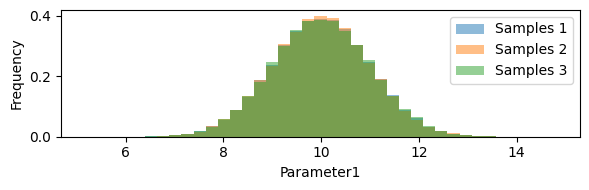

In [62]:
import matplotlib.pyplot as plt
import pints.plot

pints.plot.histogram(chains[:, 1000:, :])
plt.show()

(array([1.3600e+02, 1.9580e+03, 1.4066e+04, 5.0783e+04, 9.2363e+04,
        8.7212e+04, 4.1387e+04, 9.8410e+03, 1.1770e+03, 7.7000e+01]),
 array([ 5.83888173,  6.68780574,  7.53672975,  8.38565376,  9.23457777,
        10.08350178, 10.9324258 , 11.78134981, 12.63027382, 13.47919783,
        14.32812184]),
 <BarContainer object of 10 artists>)

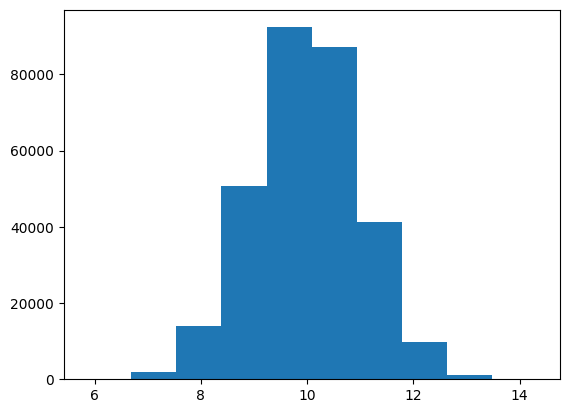

In [63]:
plt.hist(chains[0, 1000:, :])

In [64]:
chains[:, 1000:, :].mean()

np.float64(9.994317090556725)

In [66]:
from scipy.integrate import quad

# Зададим функцию плотности вероятности (PDF)
def pdf(x):
    # Пример: нормальное распределение с mu = 0, sigma = 1
    return x * np.exp(-(x - 10)**2 / 2) / np.sqrt(2 * np.pi)

quad(pdf, -np.inf, np.inf)

(10.000000000000004, 1.4165937946449083e-07)

We'll now show how you can use PINTS to apply the same technique to a higher dimensional time-series model.

## Inference on a time series model

As in [Optimisation: First example](../optimisation/first-example.ipynb), we'll use a toy model:

In [6]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, we choose an arbitrary set of "true" parameters:

In [7]:
true_parameters = [0.015, 500]

And a number of time points at which to sample:

In [8]:
times = np.linspace(0, 1000, 400)

Using these parameters and time points, we can now generate some toy data:

In [9]:
org_values = model.simulate(true_parameters, times)

...and make it more realistic by adding Gaussian noise:

In [10]:
noise = 25
values = org_values + np.random.normal(0, noise, org_values.shape)

We can use matplotlib (or any other plotting package) to look at the data we've created:

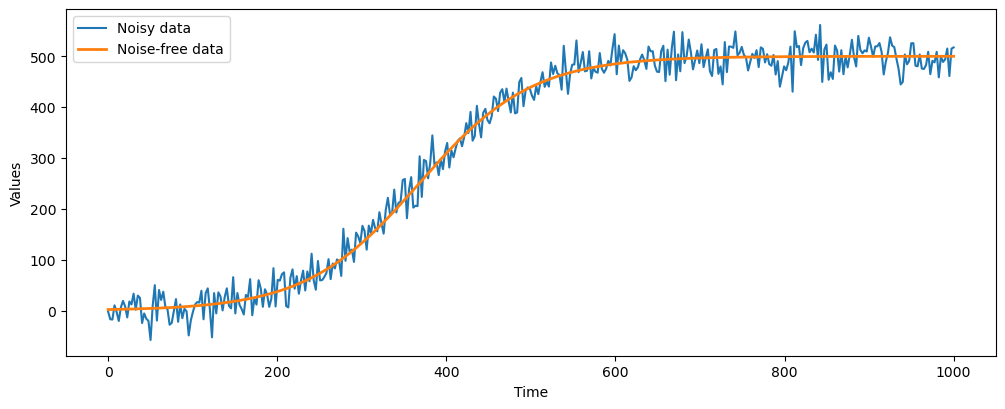

In [11]:
plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now we have enough data (a model, a list of times, and a list of data) to formulate a problem:

In [12]:
problem = pints.SingleOutputProblem(model, times, values)

We now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, we need to add a _noise model_. One way to do this is using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [13]:
log_likelihood = pints.GaussianLogLikelihood(problem)

This noise has mean zero, and an unknown standard deviation. How can we find out the standard deviation? By inferring it along with the other parameters. This means we have added one parameter to our problem!

In [14]:
print('Original problem dimension: ' + str(problem.n_parameters()))

Original problem dimension: 2


In [15]:
print('New dimension: ' + str(log_likelihood.n_parameters()))

New dimension: 3


(This means we also have to update our vector of true parameters)

In [16]:
true_parameters += [noise]
print(true_parameters)

[0.015, 500, 25]


This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

We can use this in a Bayesian inference scheme to find the quantity we're interested in:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, we now define a _prior_, indicating our initial ideas about what the parameters should be. 
Just as we're using a _log-likelihood_ (the natural logarithm of a likelihood), we'll define this using a _log-prior_. This simplifies the above equation to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example we'll assume we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [17]:
log_prior = pints.UniformLogPrior(
    [0.01, 400, 1],
    [0.02, 600, 100]
    )

With this prior, we can now define the numerator of Bayes' rule -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$:

In [18]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [19]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [20]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time    
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0.333      0:00.0
3     12     0         0         0.25       0:00.0
20    63     0.0476    0.0476    0.0476     0:00.0
40    123    0.0244    0.0244    0.0488     0:00.0
60    183    0.0328    0.0328    0.0328     0:00.0
80    243    0.0247    0.0247    0.037      0:00.0
100   303    0.0198    0.0198    0.0297     0:00.0
120   363    0.0165    0.0165    0.0248     0:00.1
140   423    0.0142    0.0213    0.0284     0:00.1
160   483    0.0124    0.0186    0.0373     0:00.1
180   543    0.011     0.0166    0.0387     0:00.1
Initial phase completed.
200   603    0.0149    0.0149    0.0348     0:00.1
220   663    0.0317    0.0271    0.0452     0:00.1
240   723    0.0622    0.0581    0.083      0:00.1
260   783   

9680  29043  0.232     0.226     0.231      0:11.0
9700  29103  0.232     0.226     0.231      0:11.1
9720  29163  0.232     0.226     0.231      0:11.1
9740  29223  0.232     0.226     0.231      0:11.1
9760  29283  0.232     0.226     0.230919   0:11.1
9780  29343  0.232     0.226     0.231      0:11.1
9800  29403  0.231609  0.226     0.231      0:11.2
9820  29463  0.232     0.226     0.231      0:11.2
9840  29523  0.232     0.226603  0.231      0:11.2
9860  29583  0.232     0.227     0.231      0:11.2
9880  29643  0.232     0.227     0.231      0:11.2
9900  29703  0.232     0.227     0.231      0:11.3
9920  29763  0.232     0.227     0.231      0:11.3
9940  29823  0.232     0.227     0.232      0:11.3
9960  29883  0.232     0.227     0.231      0:11.3
9980  29943  0.232     0.227     0.231      0:11.4
10000 30000  0.2323    0.2272    0.2313     0:11.4
Halting: Maximum number of iterations (10000) reached.


## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

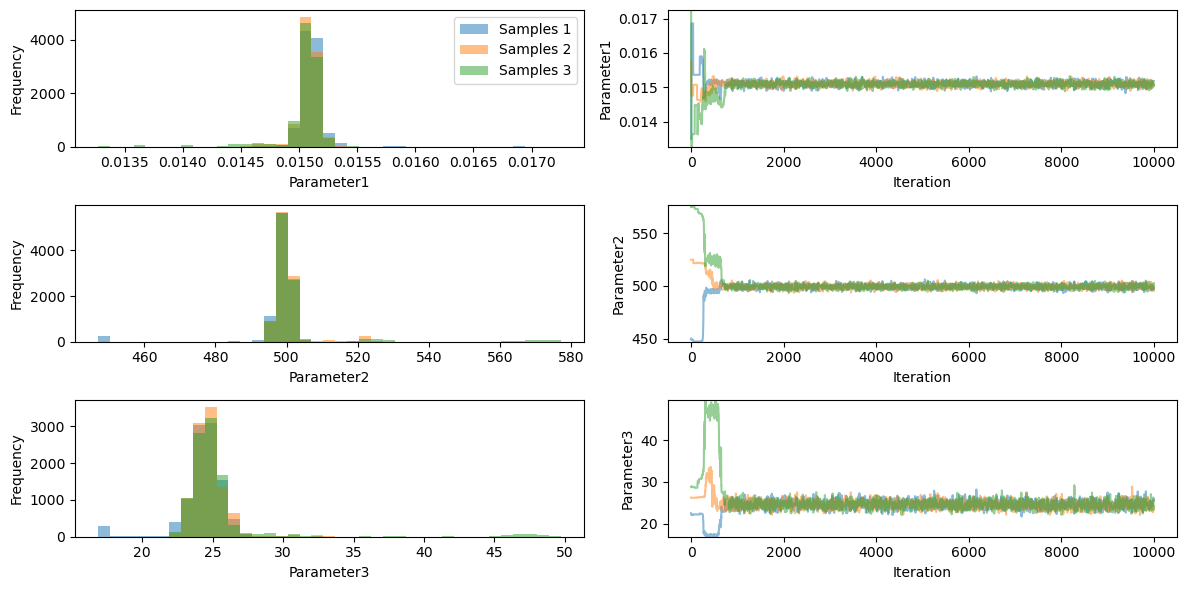

In [21]:
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [22]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

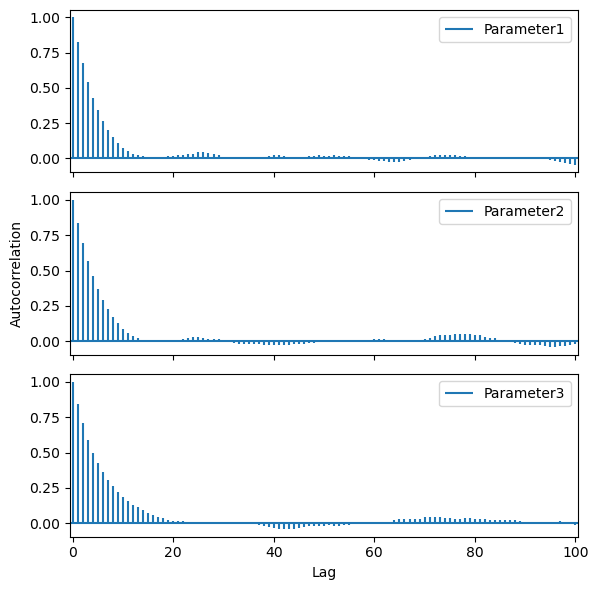

In [23]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

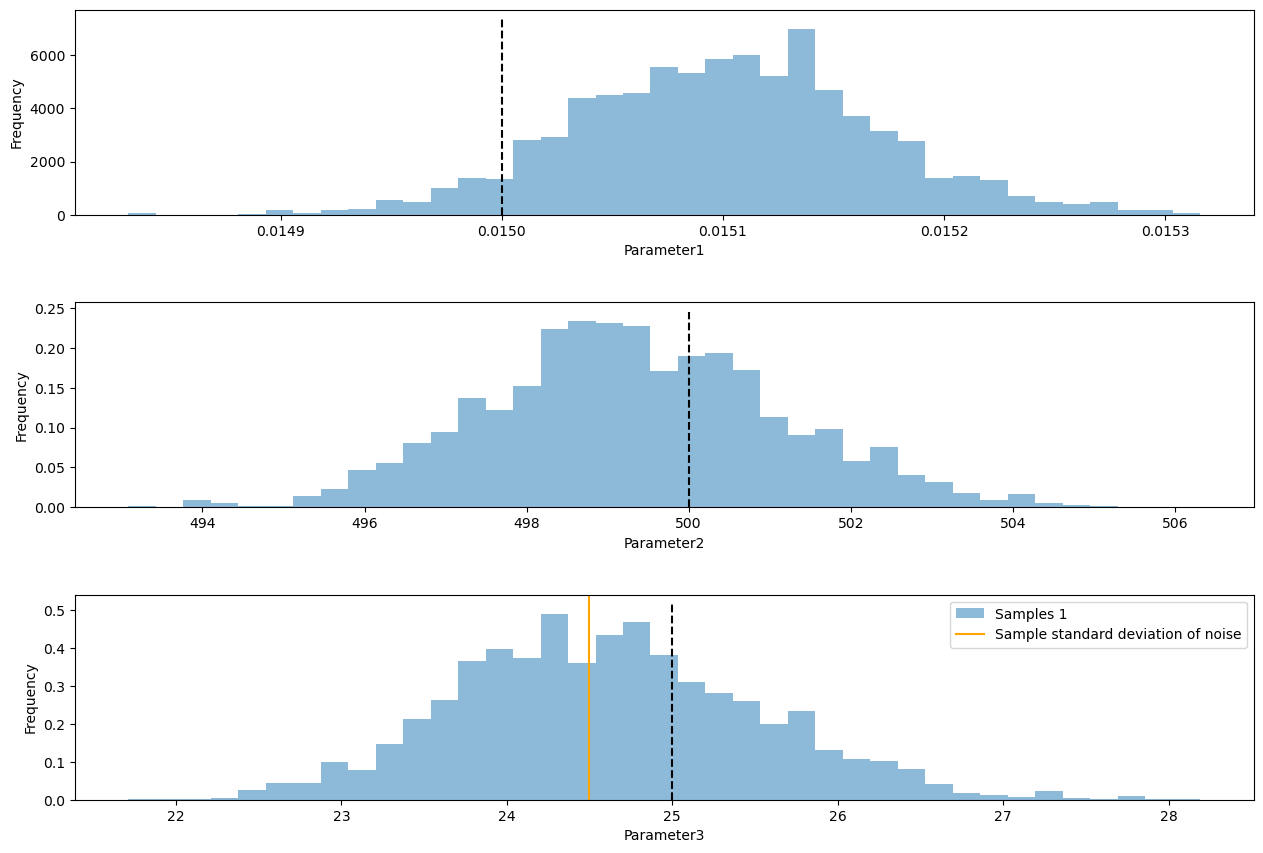

In [24]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [25]:
chain = chain[::10]

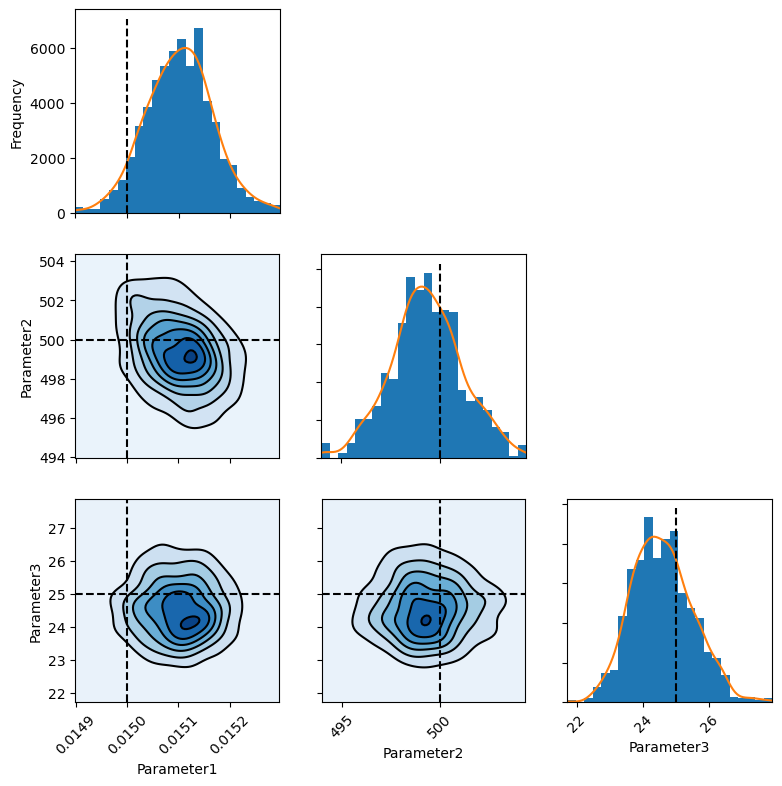

In [26]:
pints.plot.pairwise(chain, kde=True, ref_parameters=true_parameters)
plt.show()

As these plots show, we came pretty close to the original "true" values (represented by the blue line). 
But not exactly... Worse, the method seems to suggest a normal distribution but around the wrong point.
To find out what's going on, we can plot the log-posterior function near the true parameters:

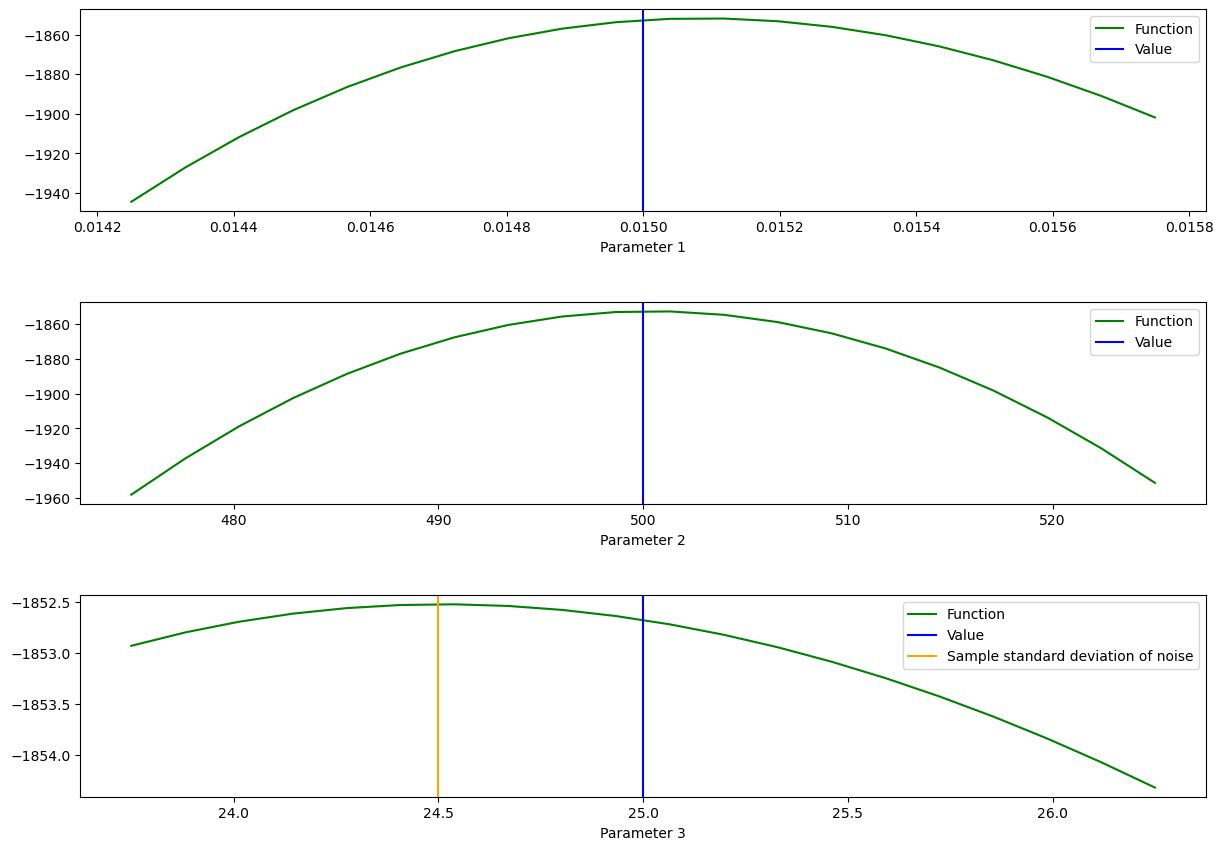

In [27]:
# Plot log-posterior function
fig, axes = pints.plot.function(log_posterior, true_parameters)

# Add a line showing the sample standard deviation of the generated noise
axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
axes[-1].legend()

# Customise the figure size
fig.set_size_inches(14, 9)
plt.show()

As this plot (created entirely without MCMC!) shows, the MCMC method did well, but our estimate of the true parameters has become _biased_ by the stochastic noise! You can test this by increasing the number of sample points, which increases the size of the noise sample, and reduces the bias.

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). These can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

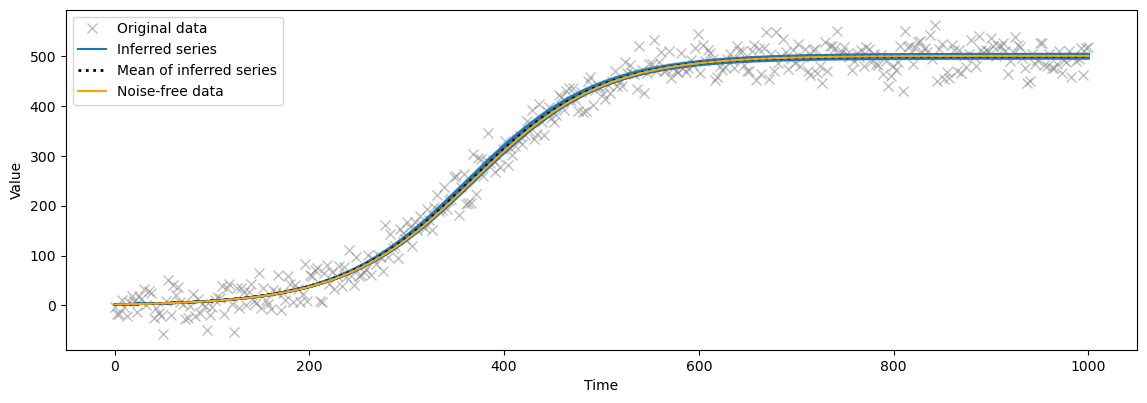

In [28]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()